binning the SST for the cloud radar data

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

def f_calc_tot_cloud_fraction(matrix):
    '''
    function to calculate the total cloud fraction of a matrix (time, height)
    

    Parameters
    ----------
    matrix : ndarray (time, height)
        DESCRIPTION. reflectivity values

    Returns
    -------
    cloud fraction ndarray(time)

    '''
    #defining ndarray to contain cloud fraction
    cloud_fraction = []
    N_tot = matrix.shape[0]
    for ind_height in range(matrix.shape[1]):
        cloud_fraction.append(np.sum(~np.isnan(matrix[:,ind_height]))/N_tot)


    return(np.asarray(cloud_fraction))

In [2]:
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

# opening ship data and reading sst
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

In [3]:
# reading radar file list
file_list = np.sort(glob.glob("/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/*.nc"))
file_list = file_list[14:16]
print(file_list)

# set the processing mode keyword for the data you want to be processed
processing_mode = 'case_study' # 'all_campaign' #

# setting time window to be checked
string_out = '20200202_20200203'
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)


data_1 = xr.open_dataset(file_list[0])
data_2 = xr.open_dataset(file_list[1])
radar_data = xr.concat([data_1, data_2], dim='time')


# selecting data in the time window of the surface anomaly
radar_data_sliced = radar_data.sel(time=slice(t_start, t_end))


['/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/20200202_wband_radar_msm_eurec4a_intake.nc'
 '/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/20200203_wband_radar_msm_eurec4a_intake.nc']


In [33]:
# calculating cloud fraction
from datetime import timedelta

# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.05)



ze_matrix = radar_data_sliced.radar_reflectivity.values
time_radar = pd.to_datetime(radar_data_sliced.time.values)
time_cloud_fraction = np.arange(time_radar[0], time_radar[-1], timedelta(minutes=15))
dim_time_out = len(time_cloud_fraction)
dim_height = np.shape(ze_matrix)[1]
cloud_fraction = np.zeros((dim_time_out, dim_height))
sst_cf = np.zeros((dim_time_out))

for itime in range(dim_time_out-1):
    data = radar_data_sliced.sel(time=slice(time_cloud_fraction[itime], time_cloud_fraction[itime+1]))
    for iheight in range(dim_height):
        cloud_fraction[itime, iheight] = np.count_nonzero(~np.isnan(data.radar_reflectivity.values[:,iheight]))/np.shape(data.radar_reflectivity.values[:,iheight])[0]

    # calculating corresponding mean SST value associated to the 15 min cloud fraction profile. 
    sst_slice = SST_DS.sel(time=slice(time_cloud_fraction[itime], time_cloud_fraction[itime+1]))
    sst_cf[itime] = sst_slice.SST.mean(dim='time', skipna=True)
    
dims = ['time', 'height']
coords = {'time':time_cloud_fraction, 'height':radar_data_sliced.height.values}
cf = xr.DataArray(dims=dims, coords=coords, data=cloud_fraction,
                 attrs={'long_name':'cloud fraction',
                        'units':''})
sst = xr.DataArray(dims=['time'], coords={'time':time_cloud_fraction}, data=sst_cf,
                 attrs={'long_name':'cloud fraction',
                        'units':''})
variables={'cloud_fraction':cf,
          'SST':sst}

cf_DS =xr.Dataset(data_vars = variables,
                       coords = coords)

# calculating mean quantities f
dataset_mean = []
dataset_std = []

# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = cf_DS.where((cf_DS.SST > SST_binned_arr[ind_bin]) & (cf_DS.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))

# concatenating datasets corresponding to SST bins on a new bin dimension
cloud_fraction_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
cloud_fraction_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')


(100.0, 2000.0)

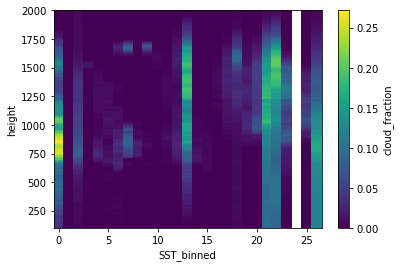

In [34]:
cloud_fraction_concat.cloud_fraction.plot(x='SST_binned', y='height')
plt.ylim(100., 2000.)

In [7]:
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    
def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)



In [9]:
# applying interpolating and binning functions to arthus_all data

radar_data_SST = f_interpolate_SST_and_merge(SST_DS, radar_data_sliced)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)


# calculating mean quantities f
dataset_mean = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = radar_data_SST.where((radar_data_SST.SST > SST_binned_arr[ind_bin]) & (radar_data_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
radar_data_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')

In [10]:
radar_data_concat

<xarray.Dataset>
Dimensions:                 (SST_binned: 55, height: 550)
Coordinates:
  * height                  (height) float32 104.4 111.8 ... 9.949e+03 9.983e+03
Dimensions without coordinates: SST_binned
Data variables: (12/14)
    rain_rate               (SST_binned) float32 0.0 0.0 0.0 ... 0.0 0.0006654
    relative_humidity       (SST_binned) float32 0.6609 0.6757 ... 0.6871 0.6743
    air_temperature         (SST_binned) float32 300.9 300.4 ... 300.0 300.2
    air_pressure            (SST_binned) float32 1.015e+03 ... 1.013e+03
    wind_speed              (SST_binned) float32 8.649 13.59 ... 5.725 6.274
    wind_direction          (SST_binned) float32 117.7 86.28 ... 100.9 172.0
    ...                      ...
    mean_doppler_velocity   (SST_binned, height) float32 -0.7619 -0.8507 ... nan
    radar_reflectivity      (SST_binned, height) float32 -44.61 -44.1 ... nan
    spectral_width          (SST_binned, height) float32 0.09542 0.1197 ... nan
    skewness                (SST_binned, height) float32 0.19 0.218 ... nan nan
    SST                     (SST_binned) float64 26.3 26.32 ... 27.62 27.65
    n_elements              (SST_binned) float64 717.0 392.0 ... 1.052e+03

<ipython-input-11-975119c21db3>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,0].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.radar_reflectivity.values.T, cmap='inferno', vmin=-60., vmax=10)
<ipython-input-11-975119c21db3>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,1].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.mean_doppler_velocity.values.T, cmap='seismic',

(200.0, 1500.0)

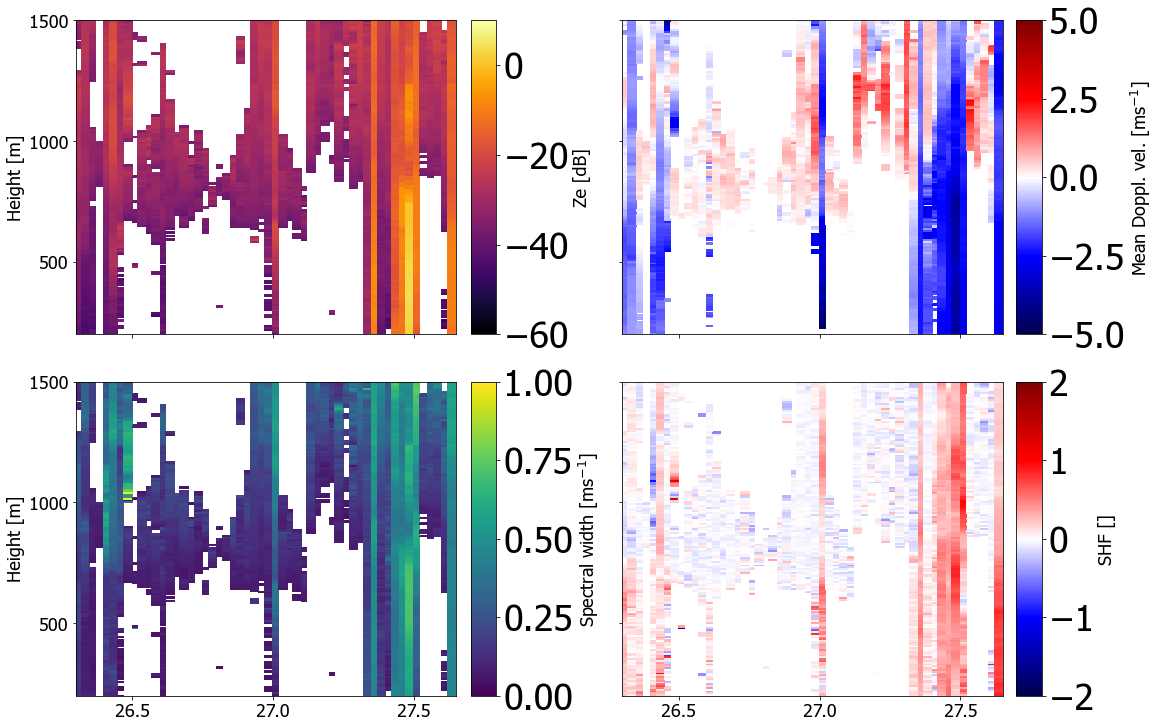

In [11]:

path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(2, 2, figsize=(16,10), sharey=True, sharex=True, constrained_layout=True)
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
val = 18
labelsizeaxes   = val
fontSizeTitle   = val
fontSizeX       = val
fontSizeY       = val
cbarAspect      = val
fontSizeCbar    = val
green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.radar_reflectivity.values.T, cmap='inferno', vmin=-60., vmax=10)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='Ze [dB]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.mean_doppler_velocity.values.T, cmap='seismic', vmin=-5., vmax=5.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='Mean Doppl. vel. [ms$^{-1}$]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.spectral_width.values.T, cmap='viridis', vmin=0., vmax=1.0)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='Spectral width [ms$^{-1}$]',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, radar_data_concat.height.values, radar_data_concat.skewness.values.T, cmap='seismic', vmin=-2., vmax=2.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF []', size=fontSizeX)
axs[1,1].set_ylim(200,1500)